<a href="https://colab.research.google.com/github/mov-z/Vision-AI-Tutorials/blob/main/huggingface/SwinT_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Huggingface SwinT Training & Evaluation**

**Huggingface** ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º Ïù¥Ïö©ÌïòÏó¨ **Swin Transformer (SwinT)** Ïù¥ÎØ∏ÏßÄ Î∂ÑÎ•ò Î™®Îç∏ÏùÑ Ïª§Ïä§ÌÖÄ Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú ÌïôÏäµÌïòÍ≥† ÌèâÍ∞ÄÌïòÎäî ÏòàÏ†ú ÏΩîÎìúÏûÖÎãàÎã§.

Ïù¥ ÏòàÏ†úÏóêÏÑúÎäî HuggingfaceÏùò **datasets**ÏôÄ **transformers** ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÌôúÏö©ÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨Î∂ÄÌÑ∞ Î™®Îç∏ ÌïôÏäµ, ÏÑ±Îä• ÌèâÍ∞ÄÍπåÏßÄÏùò Ï†Ñ Í≥ºÏ†ïÏùÑ Îã§Î£πÎãàÎã§.



## **1. ÌôòÍ≤Ω ÏÑ∏ÌåÖ**
- ÌïÑÏöî Ìå®ÌÇ§ÏßÄ ÏÑ§Ïπò
- ÎùºÏù¥Î∏åÎü¨Î¶¨ Î∞è Î™®Îìà ÏûÑÌè¨Ìä∏
- ÌïÑÏöî Ìï®Ïàò ÏÑ†Ïñ∏

In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install -q evaluate

In [22]:
from transformers import SwinConfig, AutoImageProcessor, SwinForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset
from evaluate import load as load_metric

import torch
import torchvision
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
import numpy as np
import requests
from io import BytesIO
from PIL import Image

In [15]:
def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## **2. Îç∞Ïù¥ÌÑ∞ÏÖã ÏÑ∏ÌåÖ**
- Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú Î∞è ÎùºÎ≤® Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω
- ÎùºÎ≤® Ïù∏Îç±Ïä§ ÏÉùÏÑ± (`feature_extractor`Ïóê ÌïÑÏöî)


In [4]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
dataset = load_dataset("cats_vs_dogs")

In [5]:
# datasetÏùò featuresÏùò 'image', 'labels' Î•º ÌÜµÏùºÏãúÏºúÏ£ºÎäî Í≤å Ìé∏Î¶¨
# Îç∞Ïù¥ÌÑ∞ÏÖãÎßàÎã§ 'img', 'image', 'images' Îì± Îã§ÏñëÌïòÍ≤å ÌëúÍ∏∞ÎêòÏñ¥ ÏûàÏùå
print('Í∏∞Ï°¥ :', dataset)
dataset['train'] = dataset['train'].rename_column("labels", "label")
print('Î≥ÄÍ≤Ω ÌõÑ :',dataset)

# Î†àÏù¥Î∏î Ïù∏Îç±Ïä§ Î≥Ñ Î†àÏù¥Î∏î ÏßÄÏ†ï
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print('Ïù∏Îç±Ïä§ Î≥Ñ Î†àÏù¥Î∏î : ',id2label)

Í∏∞Ï°¥ : DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})
Î≥ÄÍ≤Ω ÌõÑ : DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 23410
    })
})
Ïù∏Îç±Ïä§ Î≥Ñ Î†àÏù¥Î∏î :  {0: 'cat', 1: 'dog'}


## **3. SwinT Î™®Îç∏ ÏÑ§Ï†ï**
- Swin Î™®Îç∏Ïùò ÏÑ§Ï†ïÏùÑ Íµ¨ÏÑ±ÌïòÍ≥†, ÏÇ¨Ï†Ñ ÌïôÏäµÎêú Î™®Îç∏ÏùÑ Î°úÎìú
- Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨Î•º ÏúÑÌï¥ `AutoImageProcessor'Î•º Î∂àÎü¨Ïò§Í≥† Î†àÏù¥Î∏î Îß§Ìïë ÏÑ§Ï†ï


In [8]:
configuration = SwinConfig()
configuration.num_labels = 10

feature_extractor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224",
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes = True,
                                                       )
model = SwinForImageClassification(configuration)

## **4. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨**
- Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò ÏÑ†Ïñ∏
- Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è Î∂ÑÌï†


In [9]:
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

In [10]:
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

label : dog


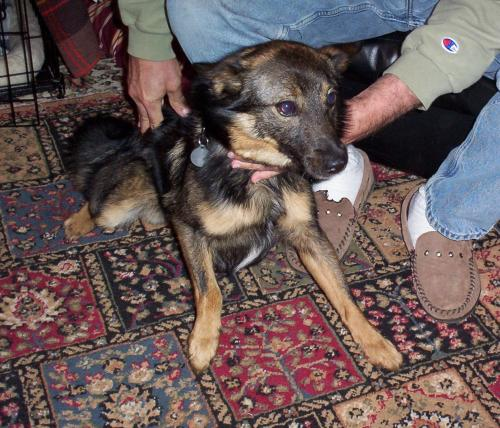

In [11]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Ïûò Ï†ÅÏö©ÎêòÏóàÎäîÏßÄ ÌôïÏù∏
example = train_ds[10]
print('label :',id2label[example['label']])
example['image']

## **5. Hugging Face `Trainer` ÏÑ§Ï†ï**
- Î∞∞Ïπò Ï†ÑÏ≤òÎ¶¨ÏôÄ Í¥ÄÎ†®Îêú Îç∞Ïù¥ÌÑ∞ ÏΩúÎ†àÏù¥ÌÑ∞ Ìï®ÏàòÏôÄ ÌïôÏäµ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞Î•º ÏÑ§Ï†ï
- Ïó¨Í∏∞ÏóêÎäî ÌïôÏäµ Î∞∞Ïπò ÏÇ¨Ïù¥Ï¶à, ÌïôÏäµ ÏÜçÎèÑ, Î°úÍπÖ Ï£ºÍ∏∞, Î™®Îç∏ ÌèâÍ∞Ä Ï†ÑÎûµ Îì±Ïù¥ Ìè¨Ìï®Îê®


In [12]:
batch_size = 32

training_args = TrainingArguments(output_dir="test_trainer",
                                  remove_unused_columns=False,
                                  evaluation_strategy = "epoch",
                                  save_strategy = "epoch",
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=batch_size,
                                  gradient_accumulation_steps=4,
                                  per_device_eval_batch_size=batch_size,
                                  num_train_epochs=2,
                                  warmup_ratio=0.1,
                                  logging_steps=10,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy",
                                  )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


## **6. Î™®Îç∏ ÌïôÏäµ**
- `Trainer` ÌÅ¥ÎûòÏä§Î•º ÏÇ¨Ïö©ÌïòÏó¨ Î™®Îç∏ÏùÑ ÌïôÏäµ
- ÌïôÏäµ Î∞è ÌèâÍ∞Ä Í≤∞Í≥ºÎ•º Î°úÍπÖ Î∞è Ï†ÄÏû•


In [17]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =       1.9909
  total_flos               = 1010492033GF
  train_loss               =       0.6316
  train_runtime            =   0:11:46.10
  train_samples_per_second =       59.677
  train_steps_per_second   =        0.465


## **7. Î™®Îç∏ ÌèâÍ∞Ä Î∞è Ï∂îÎ°†**
- ÌïôÏäµÎêú Î™®Îç∏ ÌèâÍ∞Ä
- ÌïôÏäµÎêú Î™®Îç∏ Ï∂îÎ°† Î∞è ÏãúÍ∞ÅÌôî (Ï†ÄÏû•Îêú checkpoint ÌôïÏù∏ ÌïÑÏöî)



In [18]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =     1.9909
  eval_accuracy           =     0.6548
  eval_loss               =     0.6098
  eval_runtime            = 0:00:19.09
  eval_samples_per_second =    122.603
  eval_steps_per_second   =      3.876


In [19]:
feature_extractor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
trained_model = SwinForImageClassification(configuration).from_pretrained('/content/test_trainer/checkpoint-328/')

predicted label : dog


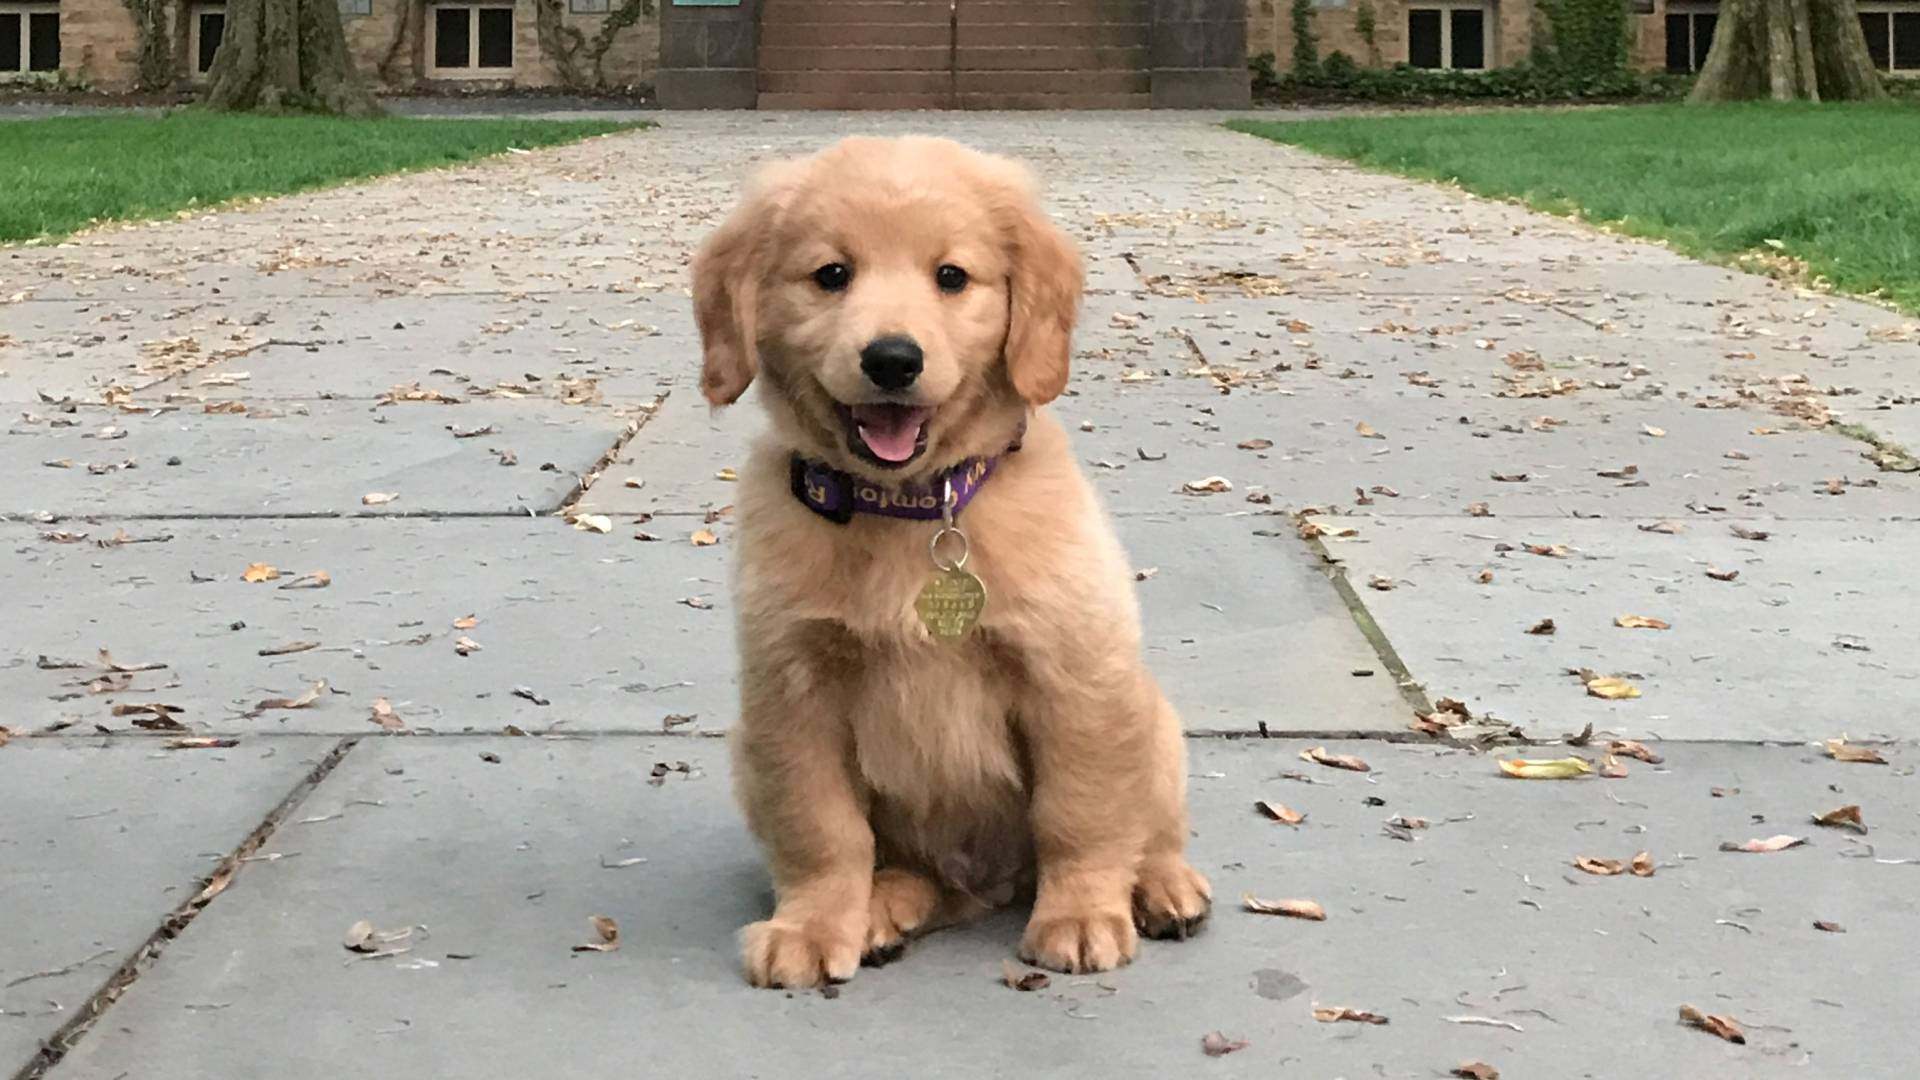

In [21]:
url = "https://www.princeton.edu/sites/default/files/styles/1x_full_2x_half_crop/public/images/2022/02/KOA_Nassau_2697x1517.jpg?itok=Bg2K7j7J"
res = requests.get(url)
image = Image.open(BytesIO(res.content))

inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    outputs = trained_model(**inputs).logits

predicted_label = outputs.argmax(-1).item()
print('predicted label :',labels[predicted_label])

image